In [ ]:
import os

def get_all_filenames(directory):

    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory '{directory}' does not exist.")
    
    # Get all files and exclude directories
    filenames = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return sorted(filenames)

# Example usage
directory_path = "data/"  # Replace with your directory path
try:
    filenames = get_all_filenames(directory_path)
    print("Filenames in directory:")
    for filename in filenames:
        rid = filename.split(".")[0]
        print(rid)
except Exception as e:
    print(f"Error: {e}")


In [ ]:
## read all the most relevant papers by gpt-4 and keep it in a list or dict per year

## read top-3 papers from llama and compute the precision or recall of relevant papers 

# Recall in this context measures the proportion of years where Llama's top-3 retrieved results include the GPT-4 most relevant paper (considered the ground truth).

In [24]:
import json

with open("../most_relevant_papers_llama.json") as f:
    llama = json.load(f)

with open("../test_data_gpt4.json") as f:
    gpt4 = json.load(f)

In [18]:
import json

with open("../final_llama.json") as f:
    llama = json.load(f)

with open("../test_data_gpt4.json") as f:
    gpt4 = json.load(f)

In [14]:
gpt4['2023'].keys(), llama['2023']['title']

(dict_keys(['1. Indomethacin Prophylaxis Is Associated with Reduced Risk of Intraventricular Hemorrhage in Extremely Preterm Infants Born in the Context of Amniotic Infection Syndrome']),
 'Indomethacin Prophylaxis Is Associated with Reduced Risk of Intraventricular Hemorrhage in Extremely Preterm Infants Born in the Context of Amniotic Infection Syndrome')

In [26]:
import re

def remove_numbering(title):
    return re.sub(r'^\d+\.\s*', '', title)

def compute_hit_rate_gpt4_in_llama(llama, gpt4):
    total_years = len(gpt4)
    hit_years = 0

    for year, gpt4_titles in gpt4.items():
        llama_titles = set()
        if year in llama:
            llama_entries = llama[year]  # Retrieve entries for the year
            if 'title' in llama_entries:
                llama_titles = {llama_entries['title']}
        
        print(llama_titles)

        normalized_gpt4_titles = {remove_numbering(title) for title in gpt4_titles}

        # Check if there's any overlap
        if normalized_gpt4_titles.intersection(llama_titles):
            hit_years += 1

    # Calculate the hit rate
    hit_rate = hit_years / total_years if total_years > 0 else 0
    print(f"Hit Rate (GPT-4 in LLaMA): {hit_rate:.2f}")
    return hit_rate


# Example usage
hit_rate_gpt4_in_llama = compute_hit_rate_gpt4_in_llama(llama, gpt4)


set()
{'Indomethacin Prophylaxis Is Associated with Reduced Risk of Intraventricular Hemorrhage in Extremely Preterm Infants Born in the Context of Amniotic Infection Syndrome'}
{'Reduction of Severe Intraventricular Hemorrhage in Preterm Infants: A Quality Improvement Project'}
set()
{'Indomethacin dosing strategy and neonatal patent ductus arteriosus closure'}
{'Prevention, Reduction and Repair of Brain Injury of the Preterm Infant'}
{'Association between prophylactic indomethacin and death or bronchopulmonary dysplasia: A systematic review and meta-analysis of observational studies.'}
{'Effect of Prophylactic Indomethacin in Extremely Low Birth Weight Infants Based on the Predicted Risk of Severe Intraventricular Hemorrhage'}
{'Effects of indomethacin prophylaxis timing on intraventricular haemorrhage and patent ductus arteriosus in extremely low birth weight infants'}
{'Placental transfusion at birth: do we have all of the answers?'}
{'Effects of Intravenous Indomethacin on Reducti

In [8]:
import re
import sys

def remove_numbering(title):
    return re.sub(r'^\d+\.\s*', '', title)

def compute_hit_rate_gpt4_in_llama(llama, gpt4):
    total_years = len(gpt4)
    hit_years = 0

    for year in gpt4.keys():
        print(llama.get(2023, []))
        sys.exit()
        llama_titles = set(map(remove_numbering, llama.get(year, []))) 
        gpt4_titles = set(map(remove_numbering, gpt4[year]))  

        if gpt4_titles.intersection(llama_titles):  
            hit_years += 1

    hit_rate = hit_years / total_years if total_years > 0 else 0
    print(f"Hit Rate (GPT-4 in LLaMA): {hit_rate:.2f}")
    return hit_rate

hit_rate_gpt4_in_llama = compute_hit_rate_gpt4_in_llama(llama, gpt4)


[]


SystemExit: 

In [26]:
import re

def remove_numbering(title):
    return re.sub(r'^\d+\.\s*', '', title)

def compute_hit_rate_gpt4_in_llama(llama, gpt4):
    total_years = len(gpt4)
    hit_years = 0

    for year in gpt4.keys():
        llama_titles = set(map(remove_numbering, llama.get(year, []))) 
        gpt4_titles = set(map(remove_numbering, gpt4[year]))  

        if gpt4_titles.intersection(llama_titles):  
            hit_years += 1

    hit_rate = hit_years / total_years if total_years > 0 else 0
    print(f"Hit Rate (GPT-4 in LLaMA): {hit_rate:.2f}")
    return hit_rate

hit_rate_gpt4_in_llama = compute_hit_rate_gpt4_in_llama(llama, gpt4)


Hit Rate (GPT-4 in LLaMA): 0.61


In [7]:
import requests
import json
import sys
sys.path.append('/srv/scratch1/rosni/scigen/')
import os
import re
import time
import openai
from openai import OpenAI
openai.api_key = os.environ["OPENAI_API_KEY"]
SEMANTIC_SCHOLAR_API_KEY = os.environ.get("S2_API_KEY", None)
import tiktoken
from transformers import pipeline
import torch

def get_citings_by_id(paper_id):
    url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}/citations'
    # Specify the fields you are interested in
    params = {
        "fields": "abstract,contexts,intents,isInfluential,year,title",
        "offset": 0,
        "limit": 1000
    }
    # Include API key in headers if needed
    api_key = os.environ.get("S2_API_KEY", None)
    headers = {
        'x-api-key': api_key  # Replace 'your_api_key_here' with your actual API key
    }
    max_retries = 3
    backoff_factor = 2
    
    for attempt in range(max_retries):
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f'Attempt {attempt + 1} failed: Status code {response.status_code}')
            time.sleep(backoff_factor * (2 ** attempt))  # Exponential backoff

    print("Failed to fetch data after retries.")
    return None

def get_paper_by_id(paper_id):
    url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}'
    # Specify the fields you are interested in
    params = {
        'fields': 'externalIds,title,year,citationCount,abstract,citations.title,citations.year,citations.paperId,citations.citationCount,citations.abstract'
    }
    # Include API key in headers if needed
    api_key = os.environ.get("S2_API_KEY", None)
    headers = {
        'x-api-key': api_key  # Replace 'your_api_key_here' with your actual API key
    }
    max_retries = 3
    backoff_factor = 2
    
    for attempt in range(max_retries):
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f'Attempt {attempt + 1} failed: Status code {response.status_code}')
            time.sleep(backoff_factor * (2 ** attempt))  # Exponential backoff

    print("Failed to fetch data after retries.")
    return None

def get_paper_data(paper_id):
    url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}'
    # Specify the fields you are interested in
    params = {
        'fields': 'externalIds,title,year,citationCount,abstract'
    }
    # Include API key in headers if needed
    api_key = os.environ.get("S2_API_KEY", None)
    headers = {
        'x-api-key': api_key  # Replace 'your_api_key_here' with your actual API key
    }
    max_retries = 3
    backoff_factor = 2
    
    for attempt in range(max_retries):
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f'Attempt {attempt + 1} failed: Status code {response.status_code}')
            time.sleep(backoff_factor * (2 ** attempt))  # Exponential backoff

    print("Failed to fetch data after retries.")
    return None

In [11]:
get_paper_by_id('PMID:3321891')

{'paperId': '264f5d9813ea623d28f0825cb9b56e8e9e8e66e9',
 'externalIds': {'MAG': '1970964364',
  'DOI': '10.1111/j.1651-2227.1987.tb17260.x',
  'CorpusId': 20418406,
  'PubMed': '3321891'},
 'title': 'Early Intravenous Indomethacin Prolongs Respiratory Support in Very Low Birth Weight Infants',
 'abstract': 'ABSTRACT. Infants weighing 1500 g at birth requiring either intermittent positive pressure ventilation or continuous positive airway pressure by 12 hours of age were entered in a randomized double blind controlled trial to test the efficacy of early intravenous indomethacin therapy in preventing chronic pulmonary disease of prematurity. Of the 30 newborns enrolled, 15 were treated with indomethacin and 15 were treated with placebo at 12, 24 and 36 hours of age. The groups were similar for birth weight, gestational age, sex, hyaline membrane disease and intracranial hemorrhage. Infants in the placebo group were successfully weaned from intermittent positive pressure ventilation at an

In [ ]:
get_paper_data('43edaf3dfe704bea74ebc68c75682cae41a58495')

In [ ]:
get_citings_by_id('PMID:3998921')

In [2]:
def extract_linear_chain(data, chain=[]):
    # If the current level has a paper, add it to the chain
    if "paper" in data:
        chain.append({
            "paperId": data["paper"]["paperId"],
            "title": data["paper"]["title"],
            "abstract": data["paper"]["abstract"],
            "year": data["paper"]["year"],
            "citation_count": data["paper"]["citation_count"],
            "relevance": data["paper"]["relevance"],
            "explanation": data["paper"]["explanation"]
        })
    
    # If there's a chain at this level, traverse it
    if "chain" in data and isinstance(data["chain"], dict):
        for year, nested_chain in data["chain"].items():
            for nested_data in nested_chain:
                extract_linear_chain(nested_data, chain)
    
    return chain

import json
# read the json data
with open("../temporal_chains_llama.json") as f:
    json_data = json.load(f)
linear_chain = []
for year, entries in json_data.items():
    for entry in entries:
        linear_chain = extract_linear_chain(entry, chain=linear_chain)

import pandas as pd
df = pd.DataFrame(linear_chain)
df = df.sort_values(by=["year"], ascending=[True])


In [12]:
df

,paperId,title,abstract,year,citation_count,relevance,explanation
0,c255df3fb3fba0205479c2d4632897f91876c9e1,"Impact of bronchopulmonary dysplasia, brain in...",CONTEXT\nDespite more than 2 decades of outcom...,2003,540,2,This paper is directly related to the source p...
1,50f69c376ccdde9a7ddcaa712ccac07105b1f5d0,"Chronic Conditions, Functional Limitations, an...",CONTEXT\nInformation on the school-age functio...,2005,1238,1,"This paper examines the chronic conditions, fu..."
2,aac266ca577d5b8148097608db85c90fe85fbdc3,Improved Neurodevelopmental Outcomes for Extre...,BACKGROUND. Neurodevelopmental impairment of e...,2007,401,2,This paper is partially dependent on the findi...
3,690ddc2eb03d864b19e286d612cc90077938ec1a,Long-Term Medical and Social Consequences of P...,As the care of premature infants has improved ...,2009,1201,1,The paper examines the long-term consequences ...
4,29e31ec682a660dfc01b870100552a27fad4001a,Preterm Birth and Childhood Psychiatric Disorders,"Epidemiologic studies have, for many years, id...",2011,501,2,This paper reviews the relationship between pr...
5,a6a0e355146104218ada59d47fd779c718dee88a,Psychiatric outcomes at age seven for very pre...,BACKGROUND\n Uncertainty remains about the ra...,2013,203,2,The key hypothesis in this paper is at least p...
6,99e8f2b0a6827911fe20bfa7f964fe3a689902e0,Structural Brain Connectivity in School-Age Pr...,Extreme prematurity and pregnancy conditions l...,2015,185,2,This paper examines the structural brain conne...
7,2a8add452e58105c515f682edc6b94077739e38e,Reinforcement of the Brain's Rich-Club Archite...,The second half of pregnancy is a crucial peri...,2016,79,2,This paper examines the effects of very preter...
8,f12a0bbb1b2fd2dae7803d0b15d197a358379fd8,Annual Research Review: Not just a small adult...,Background There has been a recent proliferati...,2017,74,1,This paper reviews neuroimaging studies invest...
9,334401b886a0f390f655f0659af290f2267dd02c,The Protracted Maturation of Associative Layer...,The human specific cognitive shift starts arou...,2019,43,2,This paper is partially dependent on the findi...


In [13]:
json_output = df.to_json(orient="records", indent=4)

with open("temporal_chains_llama_v1.json", "w") as file:
    file.write(json_output)


In [48]:
import pandas as pd

# Load data
file_path = './llama_scores.csv'
data = pd.read_csv(file_path)

# Melt the DataFrame
melted_data = pd.melt(
    data,
    id_vars=[data.columns[0]],  # First column as identifier (titles)
    var_name='Seed',            # Name for the variable column (seeds)
    value_name='Score'          # Name for the value column (scores)
)

# Display the melted DataFrame
print(melted_data)


                                                  title   Seed  Score
0     Repeated Exercise Induces Release of Soluble P...     42      2
1     Should Claudicants Receive Angioplasty or Exer...     42      1
2     Intermittent claudication should not be treate...     42      0
3     Exercise and nursing therapy for patients with...     42      0
4     Treatment of intermittent claudication with ph...     42      0
...                                                 ...    ...    ...
1295  Assessment and management of acute pain in hig...  39517      0
1296  DAILY COST PREDICTION MODEL IN NEONATAL INTENS...  39517      0
1297  Impact of bronchopulmonary dysplasia, brain in...  39517      1
1298  Indomethacin for asymptomatic patent ductus ar...  39517      1
1299  Management of Patent Ductus Arteriosus in Very...  39517      1

[1300 rows x 3 columns]


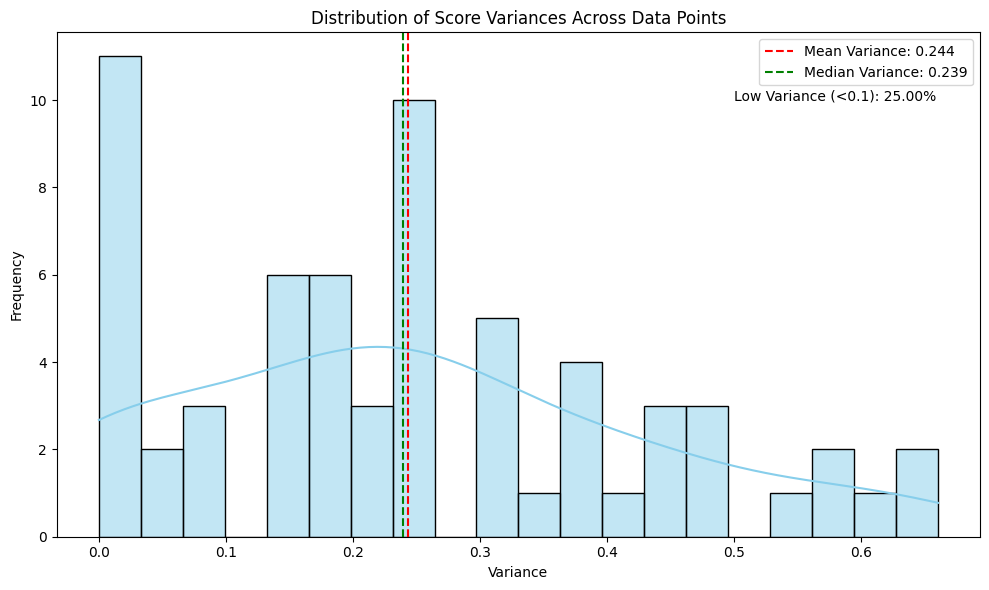

                       Metric     Value
0               Mean Variance  0.243544
1             Median Variance  0.239474
2                Min Variance       0.0
3                Max Variance  0.660526
4  Proportion of Low Variance    25.00%
5         Low Variance Points        16
6        High Variance Points         6


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute variance for each data point
variance_data = melted_data.groupby(melted_data.columns[0])['Score'].var()

# Compute descriptive statistics
mean_variance = variance_data.mean()
median_variance = variance_data.median()
min_variance = variance_data.min()
max_variance = variance_data.max()
low_variance_threshold = 0.1
low_variance_proportion = (variance_data < low_variance_threshold).mean() * 100

# Plot histogram with annotations
plt.figure(figsize=(10, 6))
sns.histplot(variance_data, bins=20, kde=True, color='skyblue')

# Add mean and median lines
plt.axvline(mean_variance, color='red', linestyle='--', label=f'Mean Variance: {mean_variance:.3f}')
plt.axvline(median_variance, color='green', linestyle='--', label=f'Median Variance: {median_variance:.3f}')

# Annotate proportion of low variance
plt.text(0.5, 10, f"Low Variance (<{low_variance_threshold}): {low_variance_proportion:.2f}%", fontsize=10)

plt.title('Distribution of Score Variances Across Data Points')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Identify data points with low and high variance
low_variance_points = variance_data[variance_data < low_variance_threshold].count()
high_variance_points = variance_data[variance_data > 0.5].count()


# Create a summary DataFrame
summary = pd.DataFrame({
    'Metric': ['Mean Variance', 'Median Variance', 'Min Variance', 'Max Variance',
               'Proportion of Low Variance', 'Low Variance Points', 'High Variance Points'],
    'Value': [mean_variance, median_variance, min_variance, max_variance,
              f"{low_variance_proportion:.2f}%", low_variance_points, high_variance_points]
})

# Display the table
print(summary)


In [40]:
import numpy as np

# Step 1: Filter high-variance data points
high_variance_threshold = 0.5
high_variance_points = variance_data[variance_data > high_variance_threshold].index

# Step 2: Extract scores for high-variance data points
high_variance_scores = melted_data[melted_data[melted_data.columns[0]].isin(high_variance_points)]

# Step 3: Group by each data point and calculate transitions
total_transitions = 0
total_0_to_2_transitions = 0
total_2_to_0_transitions = 0

for data_point in high_variance_points:
    # Get scores for the data point
    scores = high_variance_scores[high_variance_scores[melted_data.columns[0]] == data_point]['Score'].values
    
    # Calculate consecutive transitions
    transitions = list(zip(scores[:-1], scores[1:]))
    total_transitions += len(transitions)
    
    # Count 0->2 and 2->0 transitions
    total_0_to_2_transitions += transitions.count((0, 2))
    total_2_to_0_transitions += transitions.count((2, 0))

# Step 4: Compute percentages
percent_0_to_2 = (total_0_to_2_transitions / total_transitions) * 100 if total_transitions > 0 else 0
percent_2_to_0 = (total_2_to_0_transitions / total_transitions) * 100 if total_transitions > 0 else 0

# Print results
print(f"Total Transitions: {total_transitions}")
print(f"Total 0-to-2 Transitions: {total_0_to_2_transitions}")
print(f"Percent 0-to-2 Transitions: {percent_0_to_2:.2f}%")

# across all seeds

Total Transitions: 114
Total 0-to-2 Transitions: 8
Percent 0-to-2 Transitions: 7.02%


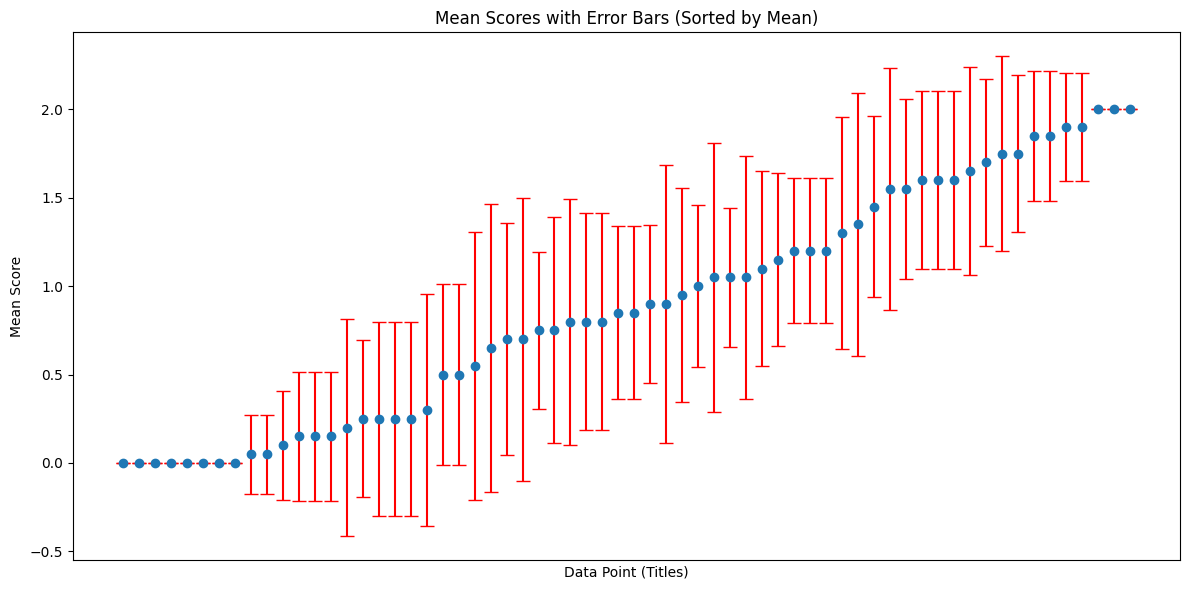

In [42]:
# Compute mean and standard deviation for each data point
stats_data = melted_data.groupby(melted_data.columns[0])['Score'].agg(['mean', 'std']).reset_index()

# Sort stats_data by mean scores
stats_data_sorted = stats_data.sort_values(by='mean', ascending=True)

# Error bar plot with sorted data
plt.figure(figsize=(12, 6))
plt.errorbar(stats_data_sorted[melted_data.columns[0]], stats_data_sorted['mean'], yerr=stats_data_sorted['std'], fmt='o', ecolor='r', capsize=5)
#plt.xticks(rotation=90)
plt.xticks([], [])
plt.title('Mean Scores with Error Bars (Sorted by Mean)')
plt.xlabel('Data Point (Titles)')
plt.ylabel('Mean Score')
plt.tight_layout()
plt.show()


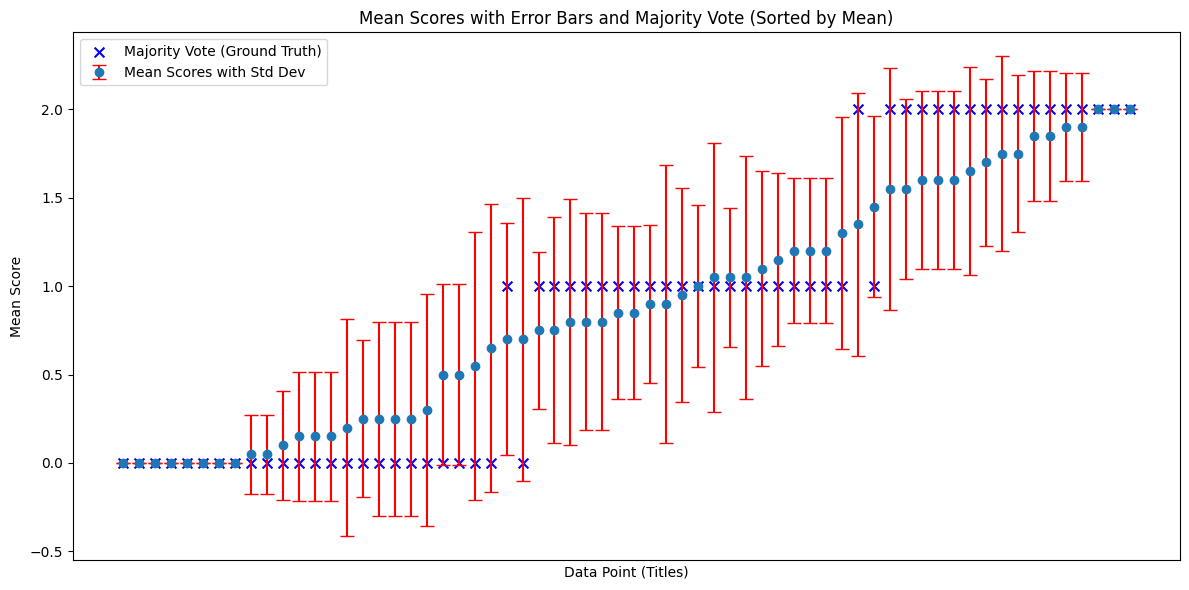

In [59]:
import numpy as np

# Compute mean and standard deviation for each data point
stats_data = melted_data.groupby(melted_data.columns[0])['Score'].agg(['mean', 'std']).reset_index()

# Compute the majority vote (mode) for each data point
majority_vote = melted_data.groupby(melted_data.columns[0])['Score'].agg(lambda x: x.mode()[0]).reset_index()
majority_vote.columns = [melted_data.columns[0], 'Majority Vote']

# Merge majority vote with stats_data
stats_data = stats_data.merge(majority_vote, on=melted_data.columns[0])

# Sort stats_data by mean scores
stats_data_sorted = stats_data.sort_values(by='mean', ascending=True)

# Error bar plot with majority vote as ground truth
plt.figure(figsize=(12, 6))
plt.errorbar(
    stats_data_sorted[melted_data.columns[0]],
    stats_data_sorted['mean'],
    yerr=stats_data_sorted['std'],
    fmt='o',
    ecolor='r',
    capsize=5,
    label='Mean Scores with Std Dev'
)

# Overlay majority-voted scores
plt.scatter(
    stats_data_sorted[melted_data.columns[0]],
    stats_data_sorted['Majority Vote'],
    color='blue',
    marker='x',
    s=50,
    label='Majority Vote (Ground Truth)'
)

plt.xticks([], [])
plt.title('Mean Scores with Error Bars and Majority Vote (Sorted by Mean)')
plt.xlabel('Data Point (Titles)')
plt.ylabel('Mean Score')
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
file_path = './llama_scores.csv'
scores = pd.read_csv(file_path)

# Extract title and seed scores
titles = scores.iloc[:, 0]  # First column (Titles)
seed_scores = scores.iloc[:, 1:]  # All other columns (Scores)

# Calculate the standard deviation across seeds for each data point
scores_std = seed_scores.std(axis=1)

# Add standard deviation as a new column to the dataframe
scores['Score Std Dev'] = scores_std

# Compute mean and max standard deviation
mean_std_dev = scores_std.mean()
max_std_dev = scores_std.max()

print(f"Mean Standard Deviation: {mean_std_dev}")
print(f"Maximum Standard Deviation: {max_std_dev}")



Mean Standard Deviation: 0.42607078296764306
Maximum Standard Deviation: 0.812727700887249


In [52]:
# Example: Compute majority vote for each data point
majority_vote = seed_scores.mode(axis=1)[0]

# Calculate seed accuracy against majority vote
seed_accuracies = {}
for seed in seed_scores.columns:
    seed_accuracies[seed] = (seed_scores[seed] == majority_vote).mean()

# Convert to DataFrame for analysis
seed_accuracies_df = pd.DataFrame(list(seed_accuracies.items()), columns=['Seed', 'Accuracy'])
seed_accuracies_df.sort_values(by='Accuracy', ascending=False, inplace=True)

print("Seed Accuracies:")
print(seed_accuracies_df)


Seed Accuracies:
      Seed  Accuracy
9   332104  0.861538
0       42  0.846154
2    11878  0.846154
14  998553  0.830769
1      123  0.830769
3   659957  0.800000
5   662817  0.800000
6   704703  0.769231
12  439967  0.753846
10  520166  0.753846
4   826888  0.753846
19   39517  0.753846
8   668517  0.738462
13  259183  0.738462
11  995273  0.707692
17  434022  0.707692
16  916101  0.692308
7    68962  0.676923
18  135613  0.661538
15  283205  0.615385



Category Distribution Per Paper:
    Score_0  Score_1  Score_2
0       0.0     16.0      4.0
1       4.0     13.0      3.0
2       7.0     11.0      2.0
3      10.0     10.0      0.0
4      17.0      3.0      0.0
..      ...      ...      ...
60     20.0      0.0      0.0
61     15.0      5.0      0.0
62      0.0      3.0     17.0
63      7.0     10.0      3.0
64     12.0      5.0      3.0

[65 rows x 3 columns]

Majority Score and Agreement:
                                                Title  Majority Score  \
0   Repeated Exercise Induces Release of Soluble P...             1.0   
1   Should Claudicants Receive Angioplasty or Exer...             1.0   
2   Intermittent claudication should not be treate...             1.0   
3   Exercise and nursing therapy for patients with...             0.0   
4   Treatment of intermittent claudication with ph...             0.0   
..                                                ...             ...   
60  Assessment and management of acute pa

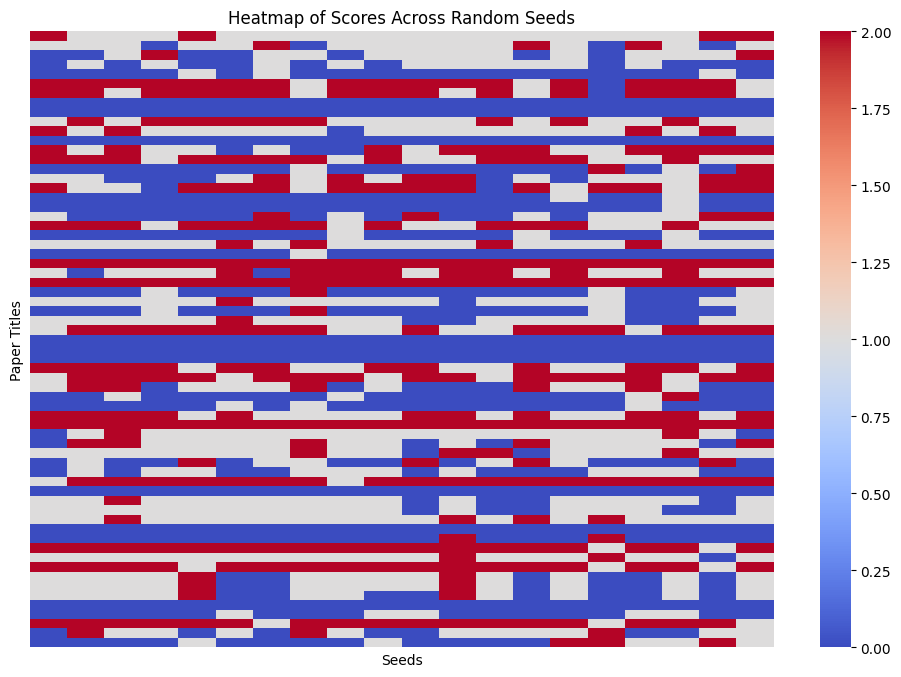

In [1]:
file_path = './llama_scores.csv'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv(file_path)

# Extract titles and scores
titles = data.iloc[:, 0]  # First column (Titles)
scores = data.iloc[:, 1:]  # Remaining columns (Scores)

# 1. Category Distribution per Paper
category_counts = scores.apply(lambda row: row.value_counts(), axis=1).fillna(0)
category_counts.columns = [f"Score_{int(col)}" for col in category_counts.columns]
print("\nCategory Distribution Per Paper:")
print(category_counts)

# 2. Majority Score
mode_scores = scores.mode(axis=1)[0]  # Extract mode for each row (paper)
agreement_with_mode = scores.apply(lambda row: (row == mode_scores[row.name]).mean(), axis=1)

print("\nMajority Score and Agreement:")
majority_stats = pd.DataFrame({
    'Title': titles,
    'Majority Score': mode_scores,
    'Agreement with Majority (%)': agreement_with_mode * 100
})
print(majority_stats)


# 3. Transition Patterns
transitions = scores.apply(lambda row: row.diff().fillna(0).abs().sum(), axis=1)
print("\nTransition Patterns (Sum of Absolute Score Changes):")
transition_stats = pd.DataFrame({
    'Title': titles,
    'Score Transitions': transitions
})
print(transition_stats)

# 4. Heatmap Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(scores, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Heatmap of Scores Across Random Seeds")
plt.xlabel("Seeds")
plt.ylabel("Paper Titles")
plt.show()



### Summary of Results

- **Category Distribution**: Papers with consistent scores (e.g., "Bipolar affective disorder") show high frequency for a single score, while others like "Poor outcome of very low birthweight babies" have a more balanced distribution, indicating variability in assessments.

- **Majority Score and Agreement**: Most papers exhibit high agreement with their majority score, with some papers (e.g., "Bipolar affective disorder") showing perfect consistency, while others (e.g., "The management of chronic lung disease") have lower agreement, suggesting variability.

- **Transition Patterns**: Papers with 0 transitions (e.g., "Bipolar affective disorder") show stable scores across seeds, while others with high transitions (e.g., "Poor outcome of very low birthweight babies") exhibit significant score variability.

- **Heatmap**: Stable papers appear with uniform color rows (consistent scores), while varied papers show mixed colors, reflecting inconsistency across runs.

This analysis suggests that most papers show consistent results, but some exhibit notable variability, indicating areas where the model's performance could be improved.

In [37]:
from statsmodels.stats.inter_rater import fleiss_kappa
import numpy as np

# Prepare the data for Fleiss' Kappa: count how often each score (0, 1, 2) appears for each paper across all seeds
score_counts = scores.apply(lambda row: [sum(row == 0), sum(row == 1), sum(row == 2)], axis=1)

score_counts_array = np.array(score_counts.tolist(), dtype=int)

fleiss_kappa_value = fleiss_kappa(score_counts_array)
print(f"Fleiss' Kappa Score: {fleiss_kappa_value}") # moderately consistent 


Fleiss' Kappa Score: 0.4307710074698494


In [40]:
transitions.mean()

7.826086956521739

In [23]:
### Consistency input data creation

import json
import pandas as pd

# read json 
with open("../llama_outputs_CD000017_log_p1.json") as f:
    data = json.load(f)

title_dict = {}

for entry in data:
    seed = entry['seed']
    llama_output = entry.get('llama_output', {})
    paper_list = llama_output.get('paper_list', {})
    
    # Process each title and store relevance scores with seeds
    for title, details in paper_list.items():
        if title not in title_dict:
            title_dict[title] = {}
        title_dict[title][seed] = details.get('relevance', 0)

# Convert the dictionary into a DataFrame
df = pd.DataFrame.from_dict(title_dict, orient='index').reset_index()

# Rename the first column to 'title'
df.rename(columns={'index': 'title'}, inplace=True)


df

,title,42,123,11878,659957,826888,662817,704703,68962,668517,...,520166,995273,439967,259183,998553,283205,916101,434022,135613,39517
0,1. Repeated Exercise Induces Release of Solubl...,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
1,2. Should Claudicants Receive Angioplasty or E...,1.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,...,1.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,0.0,1.0
2,3. Intermittent claudication should not be tre...,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0
3,1. Should Claudicants Receive Angioplasty or J...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,NaN,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
4,2. Angioplasty (versus non surgical management...,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0
5,1. Exercise and nursing therapy for patients w...,0.0,NaN,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,0.0,NaN,0.0
6,2. Treatment of intermittent claudication with...,0.0,NaN,0.0,NaN,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
7,3. Outcome of femoropopliteal angioplasty,2.0,NaN,2.0,NaN,2.0,2.0,2.0,1.0,2.0,...,2.0,2.0,2.0,1.0,2.0,NaN,2.0,2.0,NaN,1.0
8,4. Outcome of the first 100 femoropopliteal an...,2.0,NaN,1.0,NaN,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,2.0,1.0,2.0,NaN,2.0,2.0,NaN,1.0
9,1. Exercise and nursing therapy for patients w...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN


In [24]:
df.to_csv('CD000017_p1.csv', index=False)
